<a href="https://colab.research.google.com/github/ValentinRicher/understanding-decision-trees/blob/master/understanding_decision_trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1- Importing libraries

In [0]:
import pandas as pd
import numpy as np
from sklearn import datasets
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import tree
import graphviz

## 2- Loading the data

In [15]:
iris = datasets.load_iris()
iris_df = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                     columns= iris['feature_names'] + ['target'])
iris_df.head(10)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0
5,5.4,3.9,1.7,0.4,0.0
6,4.6,3.4,1.4,0.3,0.0
7,5.0,3.4,1.5,0.2,0.0
8,4.4,2.9,1.4,0.2,0.0
9,4.9,3.1,1.5,0.1,0.0


## 2- Data exploration

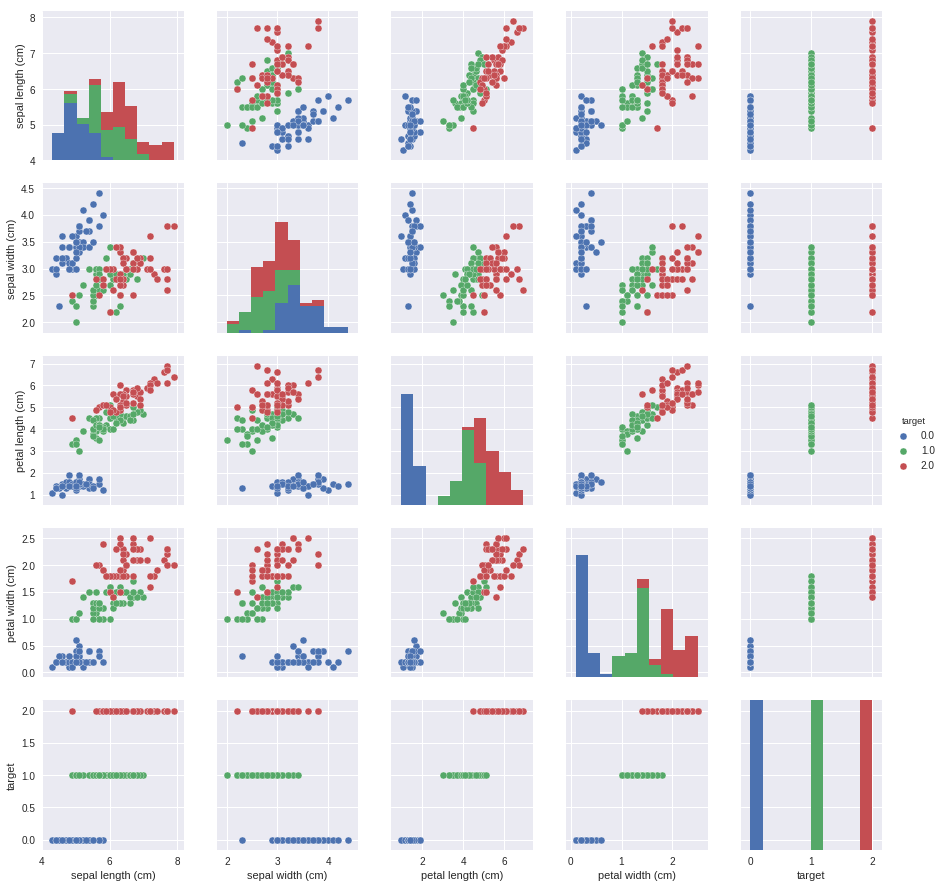

In [16]:
sns.pairplot(iris_df, hue='target')

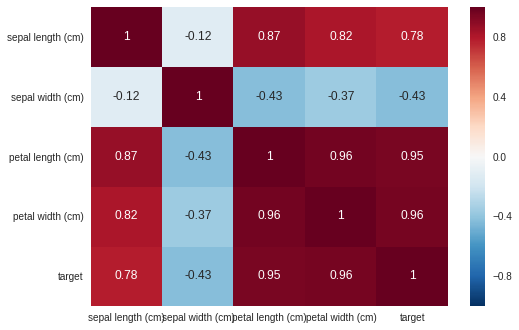

In [17]:
corr = iris_df.corr()
sns.heatmap(corr, annot=True)

## 3- Preparing the data

### Getting the names of the target

In [0]:
iris_df['target'] = iris_df['target'].map({0: iris['target_names'][0],
                                          1: iris['target_names'][1],
                                          2: iris['target_names'][2]})

### Feature selection

To illustrate how the decision tree works, we need to work on 2D graphs so we select two features. We select petal width and sepal width because there not too correlated (-0.37), as we can see on the heatmap, and in a 2D plane they give a good separation of the target variable as we can see on the pairplot.

In [0]:
features = ['petal width (cm)', 'sepal width (cm)']
X = iris_df[features]
y = iris_df['target']

### Splitting into training and testing set

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

## 4- Modeling

### Choosing a model

In [0]:
model = DecisionTreeClassifier()

### Training

In [33]:
model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

## 5- Evaluating the model

In [0]:
y_pred = model.predict(X_test)

### Accuracy

In [36]:
accuracy_score(y_test, y_pred)

0.9111111111111111

The accuracy is not very good but it is not what interests us in this notebook. Btw, we only choose two variables. Let's see for which classes the model makes mistakes.

### Confusion matrix

Text(0.5, 1.0, 'Confusion matrix')

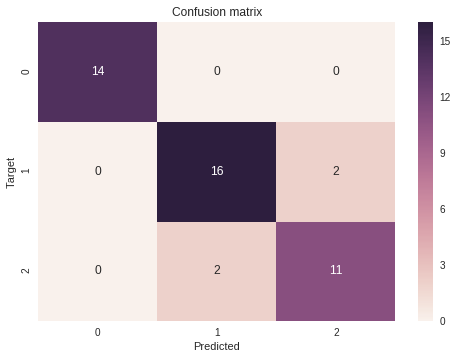

In [42]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Target')
plt.title('Confusion matrix')

## 6- Understanding how the model builds its decision
Having a good prediction is interesting but understanding how the model has build its predicting path is essential. <br/>
In the following section, we will study the previous given graph step by step for each depth of the graph. <br/>
After this section you will be able to :
*  decrypt a decision tree
*  understand the concept of decision boundary


### Tree graph

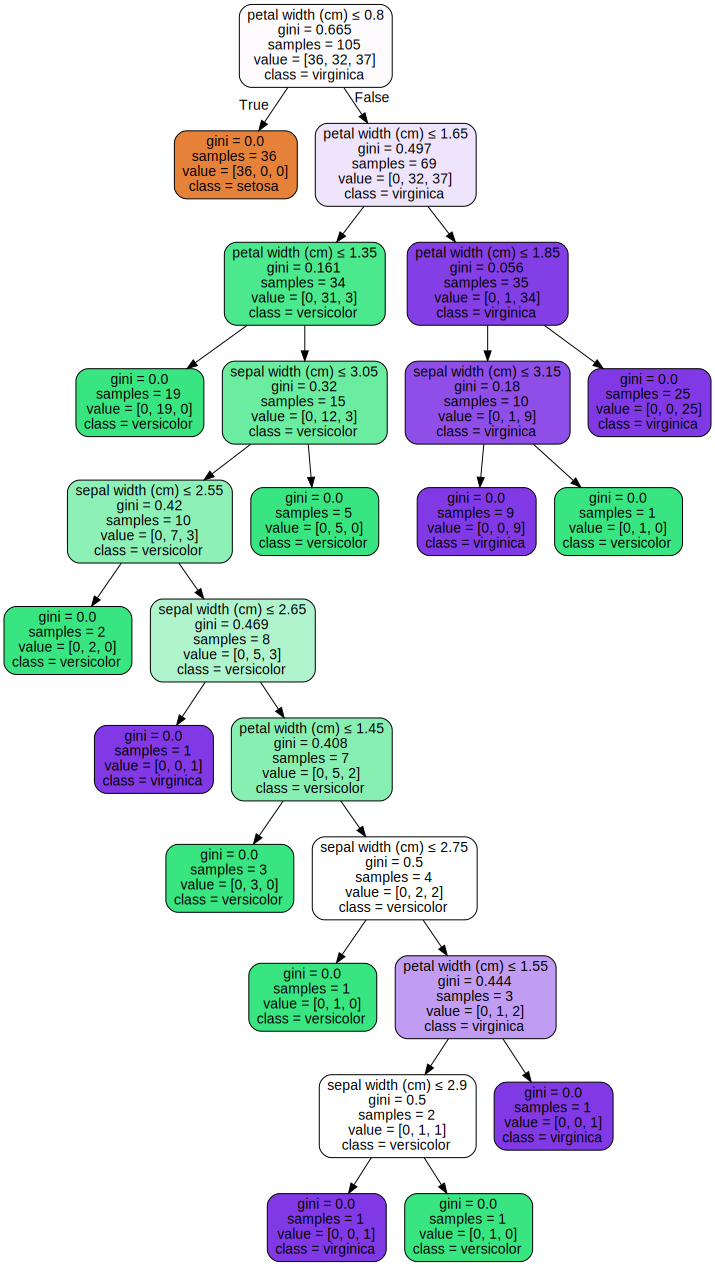

In [57]:
dot_data = tree.export_graphviz(model, out_file=None, 
                                feature_names=features,  
                                class_names=iris.target_names,  
                                filled=True, rounded=True,  
                                special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

### Analysing the tree

In [0]:
def get_lines(depth, lim, node_n=0):
  '''
  Fetches the lines corresponding to the decision boundaries for the tree
  at given depth
  depth : depth maximum where to fetch the lines
  lim : the frame defined to plot the graph
  node_n : node to fetch the lines
  '''
  seg = np.zeros((2,2))

  if depth==-1:
    return seg
  else:
    f = model.tree_.feature[node_n]

    lc_node_n = model.tree_.children_left[node_n]
    rc_node_n = model.tree_.children_right[node_n]

    if f<0:
      return seg
    else:
      thres = model.tree_.threshold[node_n]

      seg[f,:] = thres
      seg[1-f,:] = lim[1-f,:]

      if (lc_node_n==-1) and (rc_node_n)==-1:
        return seg
      else:
        l_lim = lim.copy()
        r_lim = lim.copy()

        l_lim[f, 1] = float(thres)
        r_lim[f, 0] = float(thres)

        seg = np.concatenate((seg, get_lines(depth-1, l_lim, lc_node_n)), axis=0) if not np.array_equal(get_lines(depth-1, l_lim, lc_node_n), np.zeros((2,2))) else seg
        seg = np.concatenate((seg, get_lines(depth-1, r_lim, rc_node_n)), axis=0) if not np.array_equal(get_lines(depth-1, r_lim, rc_node_n), np.zeros((2,2))) else seg
        return seg
      
    
def get_decision_boundaries(depth, lim):
  '''
  Wrapper and formatter of the get_lines function
  '''
  segs = get_lines(depth, lim)
  segments = []
  for i in range(0,len(segs),2):
    segments.append(segs[i:i+2,:])
  return segments



In [0]:
def get_pred(feat, depth, node_n=0):
  '''
  Get the predictions of the decision tree at a given depth.
  feat : coordinates (features) of the point
  depth : depth at which the prediction is computed
  node_n : node_n deciding the prediction
  '''
  f = model.tree_.feature[node_n]
  # leaf
  if f<0:
    pred = np.argmax(model.tree_.value[node_n])
    return pred
  elif depth==0:
    pred = np.argmax(model.tree_.value[node_n])
    return pred
  else:
    if (feat[f]<=model.tree_.threshold[node_n]):
      lc_node_n = model.tree_.children_left[node_n]
      return get_pred(feat, depth-1, lc_node_n)
    else:
      rc_node_n = model.tree_.children_right[node_n]
      return get_pred(feat, depth-1, rc_node_n)

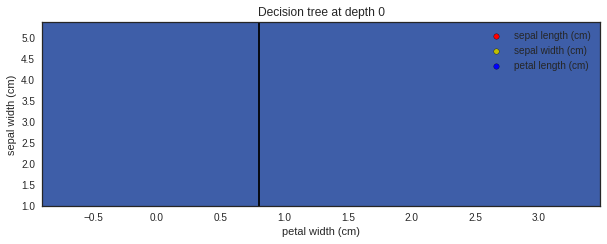

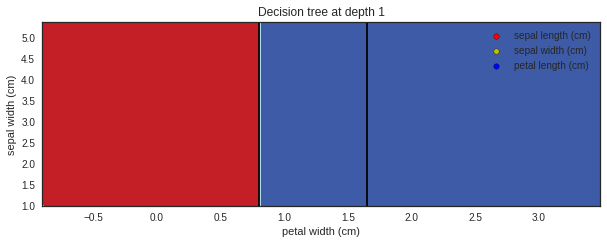

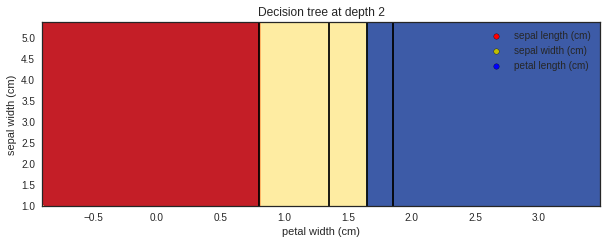

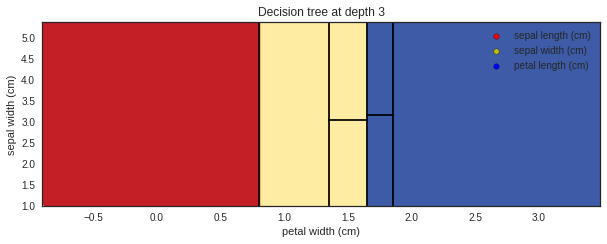

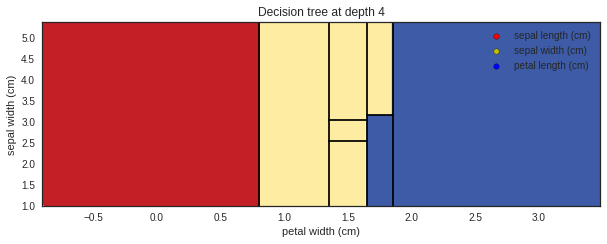

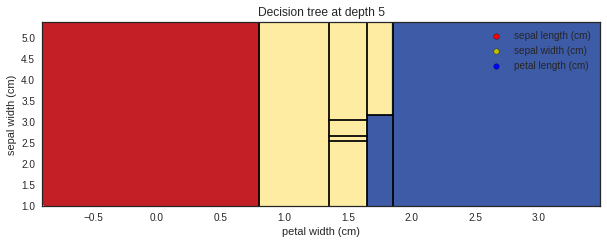

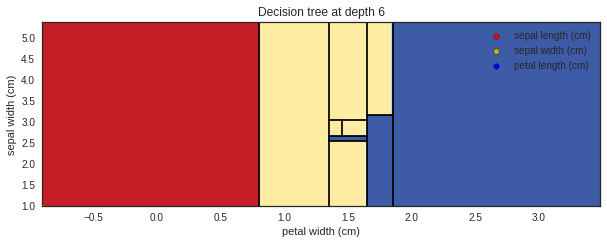

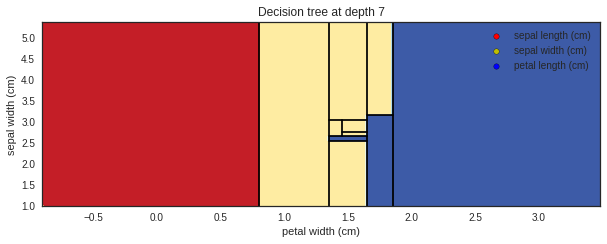

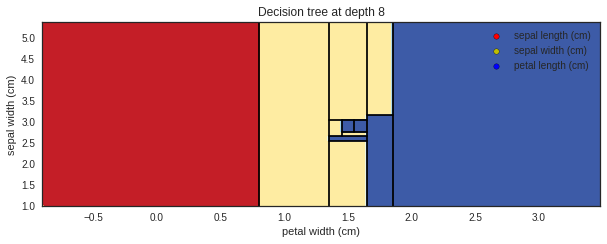

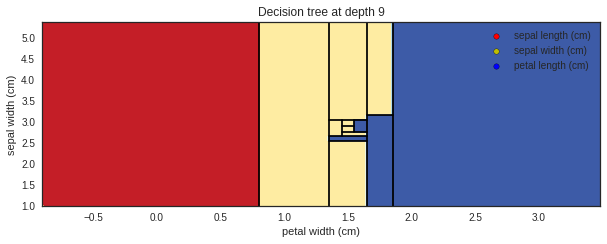

In [50]:
plt.style.use('seaborn-white')

labels = iris['feature_names']
plot_colors = 'ryb'
plot_step = 0.02

# We define a grid of points from which we will make predictions
x_min, x_max = X_train.iloc[:, 0].min() - 1, X_train.iloc[:, 0].max() + 1
y_min, y_max = X_train.iloc[:, 1].min() - 1, X_train.iloc[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))

lim = np.array([[x_min, x_max-0.02],[y_min,y_max-0.05]])
tree_depth = model.tree_.max_depth

for i in range(tree_depth):
    plt.figure(figsize=(10,40))
    plt.subplot(tree_depth, 1, i+1)
    
    # Plot the background color which depicts the decision of the tree
    Z = []
    for feat in np.c_[xx.ravel(), yy.ravel()]:
        Z.append(get_pred(feat,i))
    Z[0]=1
    Z = np.array(Z).reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu, zorder=0)
    
    # Plot the boundaries of the decision tree
    segments = get_decision_boundaries(i, lim)
    for seg in segments:
      plt.plot(seg[0,:], seg[1,:], 'k-')

    # Plot the training data
    for j, (species, color) in enumerate(zip(labels, plot_colors)):
        idx = y_train.index[y_train==species]
        plt.scatter(X_train.loc[idx][features[0]], X_train.loc[idx][features[1]], c=color, label=labels[j], cmap=plt.cm.RdYlBu, edgecolor='black', s=30, zorder=1)
    
    legend = plt.legend()
    plt.xlabel(features[0])
    plt.ylabel(features[1])
    plt.title('Decision tree at depth {}'.format(i))
    
    

